# Предсказание возраста покупателей по фото
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель** - построить модель, которая по фотографии определит приблизительный возраст человека. 

В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
image_gen = ImageDataGenerator(rescale=1./255)
image_batch = image_gen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

В нашем распоряжении 7591 фотография!

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков в данных нет!

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


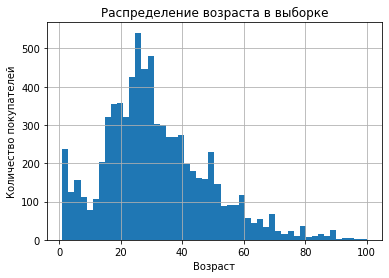

In [6]:
plt.hist(labels['real_age'], bins=50)
plt.title('Распределение возраста в выборке')
plt.ylabel('Количество покупателей')
plt.xlabel('Возраст')
plt.grid()
plt.show()

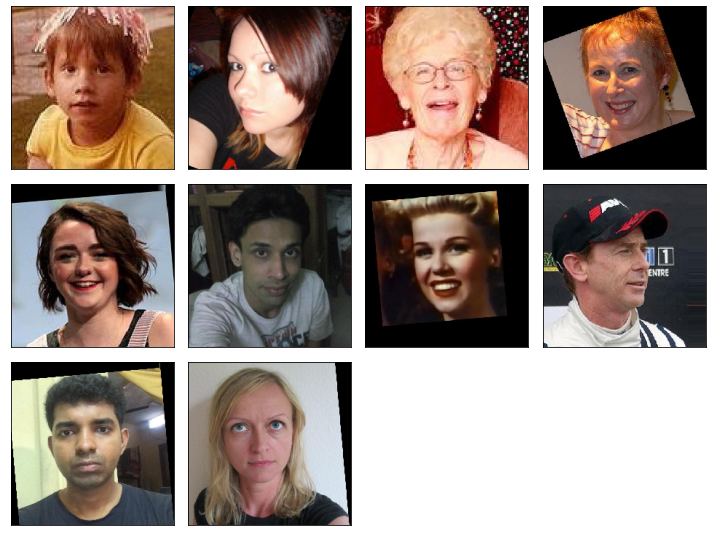

In [7]:
features, target = next(image_batch)
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы
- В нашем распоряжении датасет из 7591 фотографии, размеченной по возрасту
- Описательные метрики выборки совпадают с графиком. Мы видим, что максимальное количество покупателей приходится на возраст около 29 лет. Возраст основной массы людей на фотографиях находится в диапазоне между 20 и 41 годом. Распределение данных близко к нормальному.
- В датасете представлены фото мужчин и женщин различных возрастов. 

## Обучение модели

```python


def load_train(path):
    labels = pd.read_csv(path +'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
        
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
        
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model 

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-03-10 21:17:36.398943: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-10 21:17:38.680690: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 65s - loss: 249.7550 - mae: 11.1667 - val_loss: 1002.9247 - val_mae: 26.9744
Epoch 2/10
178/178 - 37s - loss: 65.4059 - mae: 6.0306 - val_loss: 571.4496 - val_mae: 18.4306
Epoch 3/10
178/178 - 37s - loss: 30.7155 - mae: 4.2573 - val_loss: 241.4085 - val_mae: 11.6228
Epoch 4/10
178/178 - 37s - loss: 18.4666 - mae: 3.3237 - val_loss: 110.2243 - val_mae: 7.9688
Epoch 5/10
178/178 - 37s - loss: 13.4532 - mae: 2.8181 - val_loss: 75.6264 - val_mae: 6.7494
Epoch 6/10
178/178 - 37s - loss: 11.9808 - mae: 2.6579 - val_loss: 73.4799 - val_mae: 6.3968
Epoch 7/10
178/178 - 37s - loss: 10.4103 - mae: 2.4494 - val_loss: 66.9567 - val_mae: 6.2031
Epoch 8/10
178/178 - 37s - loss: 8.4019 - mae: 2.1970 - val_loss: 71.2619 - val_mae: 6.4394
Epoch 9/10
178/178 - 37s - loss: 8.0137 - mae: 2.1351 - val_loss: 76.5735 - val_mae: 6.4289
Epoch 10/10
178/178 - 37s - loss: 7.2632 - mae: 2.0272 - val_loss: 68.6203 - val_mae: 6.1326
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 68.6203 - mae: 6.1326
Test MAE: 6.1326


```

## Анализ обученной модели

Проверим нашу нейросеть на адекватность. Для этого сравним разработанную нейронную сеть с моделью, которая всем картинкам в качестве прогноза возраста покупателя будет выдавать среднее значение возраста по выборке (некий вариант dummy модели).

In [8]:
dummy_prediction = np.ones(labels.shape[0]) * labels['real_age'].mean()

In [9]:
dummy_prediction

array([31.20115927, 31.20115927, 31.20115927, ..., 31.20115927,
       31.20115927, 31.20115927])

In [10]:
mae_dummy = mean_absolute_error(labels['real_age'], dummy_prediction)

In [11]:
mae_dummy

13.317217046353193

Наша нейронная сеть показала значение **mae=6.1326**, dummy модель - **13.3172**. Нейросеть отлично справляется с поставленной задачей!

### Выводы

В ходе данного проекта нами построена нейронная сеть, которая по фотографии определяет приблизительный возраст человека. 

Для этого на начальных этапах мы ознакомились с предоставленной базой фотографий и провели исследовательский анализ данных.
- 7591 фото
- пропусков в данных нет
- средний возраст человека на фото 31 год, медиана 29 лет, межквартильный размах 20 - 41 год.

При построении нейронной сети нами была использована архитектура **ResNet50**.

Нейронная сеть показала хорошие результаты, **mae** составил **6.1326**. Данная модель будет рекомендована заказчику!